In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from dpm.visualize import (
    plot_hist, plot_model, plot_models, plot_hists, plot_mcmc
)
from dpm.monte_carlo import box_muller, marsaglia_bray
from dpm.distributions import Normal, Langevin
from dpm.mixture_models import MixtureModel
from dpm.monte_carlo import (
    metropolis_hastings, metropolis, metropolis_langevin,
    hamiltonian_monte_carlo
)
from functools import partial
import seaborn as sns
from dpm.newton import gradient
import matplotlib.ticker as ticker



colors = { 0:"#003f5c", 1:"#444e86", 2:"#955196", 3:"#dd5182", 4:"#ff6e54", 5:"#ffa600"}

# Approximating Pi

In [2]:
def plot_samples(samples, distances, n_plot=10000):
    idx = torch.randperm(min(n_plot, samples.size(0)))
    p_samples, distances = samples[idx], distances[idx]
    accepted = p_samples[distances < 1.].numpy()
    rejected = p_samples[distances >= 1.].numpy()
    plt.figure(figsize=(7, 7))
    plt.scatter(accepted[:, 0], accepted[:, 1], s=4); plt.scatter(rejected[:, 0], rejected[:, 1], s=4)
    plt.xlim(0., 1.); plt.ylim(0., 1.)
    

def sample(batch_size):
    return torch.rand((batch_size, 2))

def distance(samples):
    return samples.pow(2).sum(dim=1).sqrt()

def monte_carlo(batch_size, plot=False):
    samples = sample(batch_size)
    distances = distance(samples)
    if plot: plot_samples(samples, distances)
    ratio = 4 * (distances < 1.).float().sum() / batch_size
    return ratio

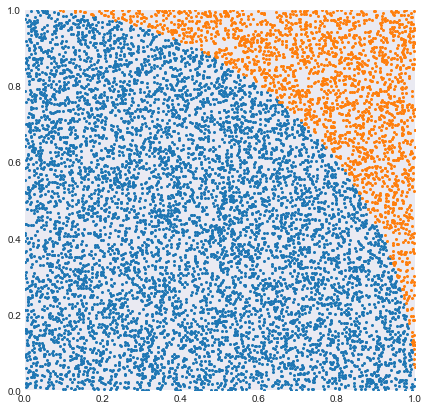

In [3]:
monte_carlo(100000, plot=True)
plt.grid(b=None)
# plt.savefig('../../Presentations/sampling/assets/approx_pi_circle.png', bbox_inches='tight', dpi=300)
plt.show()

In [4]:
def plot_monte_carlo_err(batch_size):
    samples = sample(batch_size)
    distances = distance(samples)
    print(distances.shape, samples.shape)
    ratio = 4 * torch.cumsum((distances < 1.).float(), 0) / torch.cumsum(torch.ones(batch_size).float(), 0)
    return ratio

torch.Size([100000]) torch.Size([100000, 2])


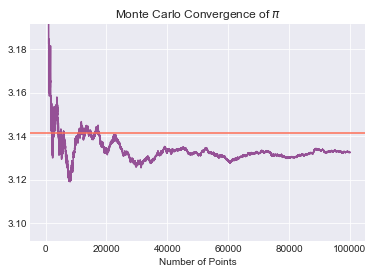

In [5]:
plt.plot(plot_monte_carlo_err(100000).numpy(), color="#955196")
plt.ylim(np.pi-0.05, np.pi+.05)
plt.axhline(np.pi, color='#ff6e54')
plt.title(r"Monte Carlo Convergence of $\pi$")
plt.xlabel('Number of Points')
# plt.grid(b=None)
# plt.savefig('../../Presentations/sampling/assets/approx_pi_error.png', bbox_inches='tight', dpi=300)
plt.show()

# LCG

In [6]:
from dpm.monte_carlo import rand, lcg

g = lcg()
for i in range(10):
    print(next(g))

1680588
675057779
713713492
1295248114
689724154
1311030043
827663638
1788785909
852207936
356854227


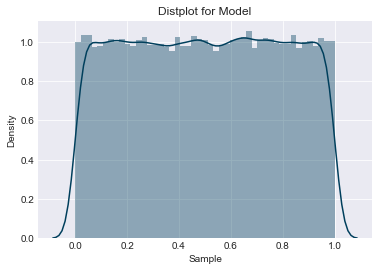

In [7]:
plot_hist(rand(100000, generator=g))

# Box Muller

In [9]:
# Works!
Z1, Z2 = box_muller()
print(Z1.shape, Z2.shape)
print(Z1.mean(), Z1.var())
print(Z2.mean(), Z2.var())

torch.Size([10000, 1]) torch.Size([10000, 1])
tensor(0.0022) tensor(0.9847)
tensor(-0.0025) tensor(1.0036)


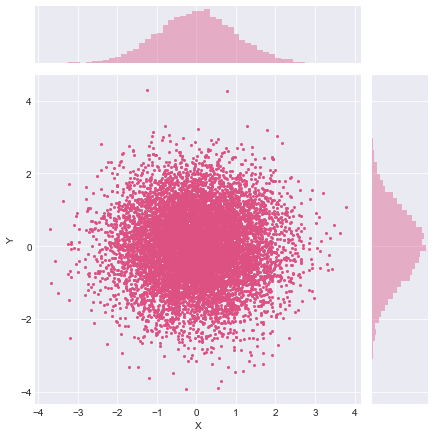

In [10]:
plot_hist(torch.cat((Z1, Z2), dim=1))
plt.show()

# Marsaglia - Bray

In [12]:
# Works!
Z1, Z2 = marsaglia_bray()
print(Z1.shape, Z2.shape)
print(Z1.mean(), Z1.var())
print(Z2.mean(), Z2.var())

torch.Size([7771, 1]) torch.Size([7771, 1])
tensor(5.4379e-05) tensor(1.0122)
tensor(-0.0059) tensor(1.0120)


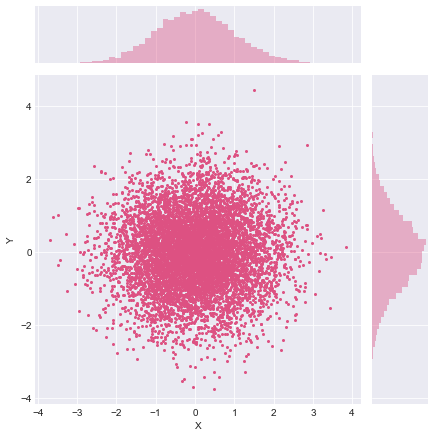

In [13]:
plot_hist(torch.cat((Z1, Z2), dim=1))
plt.show()

# Normal ICDF

In [14]:
from dpm.monte_carlo import inverse_sampling
from functools import partial

def normal_icdf(p, mu, sigma):
    return mu + sigma * np.sqrt(2.) * torch.erfinv(2 * p - 1)

n_icdf = partial(normal_icdf, mu=0., sigma=1.)

torch.Size([10000, 1])
tensor([0.0098]) tensor([0.9997])


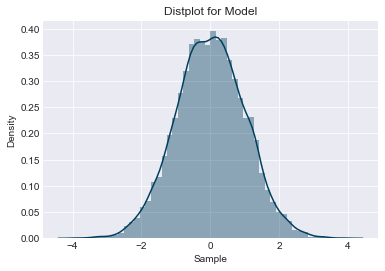

In [15]:
samples = inverse_sampling(n_icdf)
print(samples.shape)
print(samples.mean(dim=0), samples.var(dim=0))
plot_hist(samples)

torch.Size([10000, 2])
tensor([-0.0028,  0.0217]) tensor([0.9757, 0.9993])


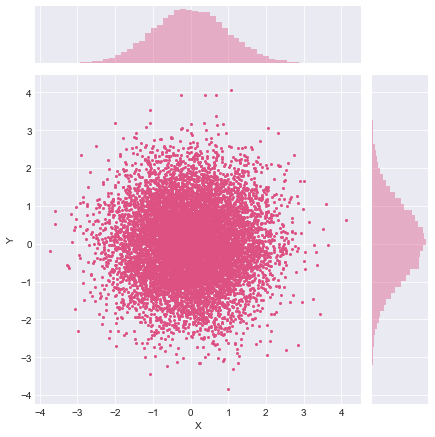

In [16]:
samples = inverse_sampling(n_icdf, n_dims=2)
print(samples.shape)
print(samples.mean(dim=0), samples.var(dim=0))
plot_hist(samples)

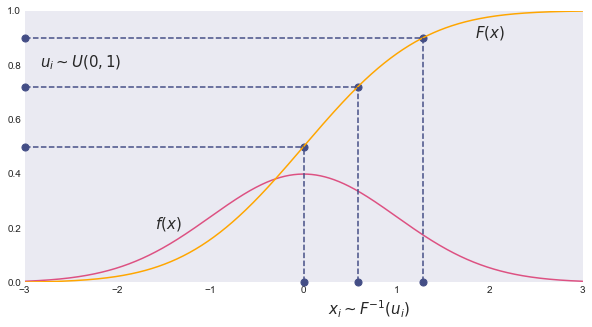

In [260]:
f_model = Normal(0., 1.)

plt.figure(figsize=(10,5))


def normal_cdf(x, mu, sigma):
    return 0.5 * (1. + torch.erf((x - mu) / (sigma * np.sqrt(2.))))

def normal_icdf(p, mu, sigma):
    return mu + sigma * np.sqrt(2.) * torch.erfinv(2 * p - 1)

x = np.linspace(-3, 3, 1000)

cdf = normal_cdf(torch.tensor(x).float(), torch.tensor(0.), torch.tensor(1.)).detach().numpy()
probs = f_model.log_prob(torch.tensor(x).float().view(-1, 1)).exp().detach().numpy()


plt.plot(x, probs, color=colors[3], label=r"$f(x)$")
plt.plot(x, cdf, color=colors[5], label=r"$F(x)$")

point_color = 1
for u in [0.5, 0.72, 0.9]:
    value = normal_icdf(torch.tensor(u), 0., 1.).item()

    plt.scatter(-3, u, s=50, color=colors[point_color], clip_on=False)
    
    plt.axhline(u, xmin=0, xmax=(value + 3) / 6. , color=colors[point_color], ls='--')
    
    plt.scatter(value, u, s=50, color=colors[point_color], clip_on=False)
    
    plt.axvline(value, ymin=0, ymax=u, color=colors[point_color], ls='--')
    
    plt.scatter(value, 0, s=50, color=colors[point_color], clip_on=False)

    
plt.annotate(r"$x_i \sim F^{-1}(u_i)$", (0.7, 0), 
     fontsize=15, xytext=(0.7, -0.12), ha='center')
    
plt.annotate(r"$u_i \sim U(0, 1)$", (-3, 0.7), 
     fontsize=15, xytext=(-2.4, 0.79), ha='center')

plt.annotate(r"$F(x)$", (2, 0.9), 
     fontsize=15, xytext=(2, 0.9), ha='center')

plt.annotate(r"$f(x)$", (-1.45, 0.2), 
     fontsize=15, xytext=(-1.45, 0.2), ha='center')

    
plt.grid(b=None)
plt.ylim(0, 1)
plt.xlim(-3, 3)

# plt.legend(loc='right', prop={'size': 15})

plt.savefig('../../Presentations/sampling/assets/icdf_transform.png', bbox_inches='tight', dpi=300)



plt.show()

# Rejection Sampling

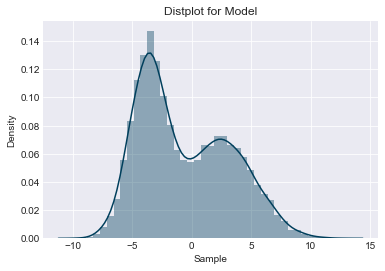

In [17]:


p_model = MixtureModel([Normal(-3.7, 2.3, learnable=False), 
                        Normal(2.6, 7.5, learnable=False)],
                       [0.5, 0.5])
q_model = Normal(0., 100., learnable=False)
plot_model(p_model)

torch.Size([10071, 1])


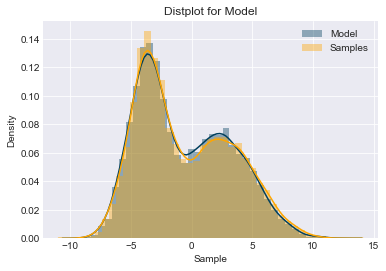

In [18]:
from dpm.monte_carlo import rejection_sampling

samples = rejection_sampling(p_model, q_model, 10, batch_size=100000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

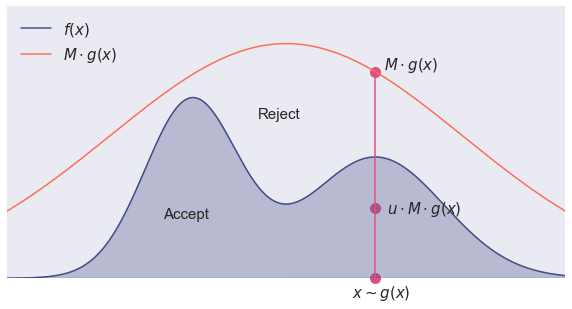

In [19]:
p_model = MixtureModel([Normal(-1.7, 0.7, learnable=False), 
                        Normal(1.6, 1.5, learnable=False)],
                       [0.5, 0.5])
q_model = Normal(0., 10., learnable=False)

M = 2.5

x = np.linspace(-7, 7, 1000).reshape(-1, 1)
plt.figure(figsize=(10,5))
p_probs = p_model.log_prob(torch.tensor(x).float()).exp().numpy()
q_probs = M*q_model.log_prob(torch.tensor(x).float()).exp().numpy()

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.plot(x, p_probs , color=colors[1], label=r"$f(x)$")
plt.plot(x, q_probs, color=colors[4], label=r"$M \cdot g(x)$")
plt.fill(x, p_probs, color=colors[1], alpha=0.3)

# x_sample = q_model.sample(1)
x_sample = torch.tensor([[1.6]])
u = 0.34
top = M * q_model.log_prob(x_sample).exp().item()
point = u * M * q_model.log_prob(x_sample).exp().item()

plt.scatter(x_sample.item(), 0, s=100, color=colors[3], clip_on=False)
plt.scatter(x_sample.item(), top, s=100, color=colors[3], clip_on=False)
plt.scatter(x_sample.item(), point, s=100, color=colors[3], clip_on=False)

plt.annotate("Accept", (-2.2, 0.08), fontsize=15)
plt.annotate("Reject", (-0.5, 0.215), fontsize=15)

plt.annotate(r"$x \sim g(x)$", (x_sample.item(), 0), 
             fontsize=15, xytext=(x_sample.item()+0.1, -0.025), ha='center')

plt.annotate(r"$M \cdot g(x)$", (x_sample.item(), top),
             fontsize=15, xytext=(x_sample.item()+0.15, top+0.004), ha='left')

plt.annotate(r"$u \cdot M \cdot g(x)$", (x_sample.item(), point),
             fontsize=15, xytext=(x_sample.item()+0.2, point-0.007), ha='left')

plt.axvline(x_sample.item(), ymin=0, ymax=top/(np.max(q_probs)+.05), color=colors[3])

plt.legend(loc='upper left', prop={'size': 15})

plt.xlim(-5, 5)
plt.ylim(0, np.max(q_probs)+.05)
plt.grid(b=None)

plt.savefig('../../Presentations/sampling/assets/rejection_sampling_explanation.png', bbox_inches='tight', dpi=300)

plt.show()

79


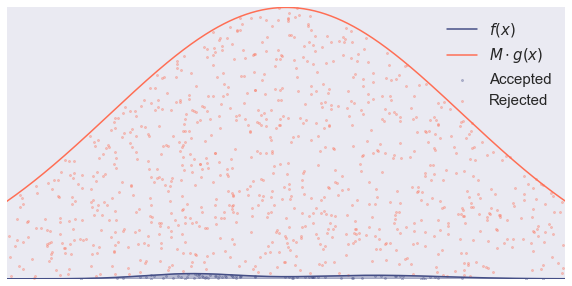

(79,)


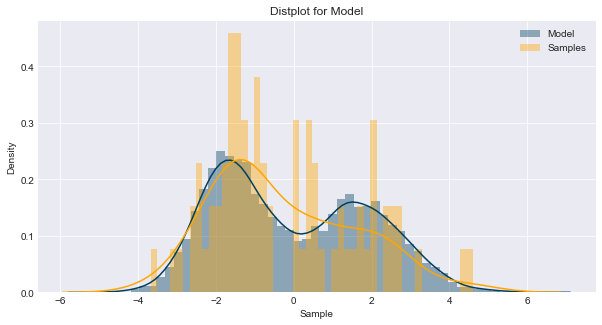

In [4]:
def rejection_sampling(model, test_model, M, batch_size=10000):
    model_samples = test_model.sample(batch_size)
    uniform_samples = torch.rand(batch_size).log()
    acceptance_ratio = (model.log_prob(model_samples) \
                       - test_model.log_prob(model_samples) \
                       - np.log(M))
    accepted = uniform_samples < acceptance_ratio
    return model_samples[accepted], model_samples[~accepted], uniform_samples[accepted].exp(), uniform_samples[~accepted].exp()

plt.figure(figsize=(10,5))


p_model = MixtureModel([Normal(-1.7, 0.7, learnable=False), 
                        Normal(1.6, 1.5, learnable=False)],
                       [0.5, 0.5])
q_model = Normal(0., 10., learnable=False)



M = 100
N = 1000

a_samples, r_samples, u_a, u_r = rejection_sampling(p_model, q_model, M, batch_size=10000)

a_probs = q_model.log_prob(a_samples).exp().view(-1)
r_probs = q_model.log_prob(r_samples).exp().view(-1)

a_samples = a_samples.view(-1).numpy()
r_samples = r_samples.view(-1).numpy()
print(len(a_samples))

a_points = (u_a * a_probs * M).numpy()
r_points = (u_r * r_probs * M).numpy()

idx = np.random.choice(range(len(a_samples)), min(N, len(a_samples)), replace=False)
a_sam = a_samples
a_points = a_points[idx]
a_samples = a_samples[idx]
idx = np.random.choice(range(len(r_samples)), min(N, len(r_samples)), replace=False)
r_points = r_points[idx]
r_samples = r_samples[idx]


plt.scatter(a_samples, a_points, color=colors[1], label="Accepted", alpha=0.3, s=4)
plt.scatter(r_samples, r_points, color=colors[4], label="Rejected", alpha=0.3, s=4)

x = np.linspace(-7, 7, 1000).reshape(-1, 1)
p_probs = p_model.log_prob(torch.tensor(x).float()).exp().numpy()
q_probs = M*q_model.log_prob(torch.tensor(x).float()).exp().numpy()

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.plot(x, p_probs , color=colors[1], label=r"$f(x)$")
plt.plot(x, q_probs, color=colors[4], label=r"$M \cdot g(x)$")
plt.fill(x, p_probs, color=colors[1], alpha=0.3)

plt.legend(loc='best', prop={'size': 15})

plt.xlim(-5, 5)
plt.ylim(0, max(np.max(q_probs), np.max(p_probs))+.02)
plt.grid(b=None)

# plt.savefig(f'../../Presentations/sampling/assets/rs_m_1_3.png', bbox_inches='tight', dpi=300)

plt.show()

plt.figure(figsize=(10,5))
plot_hists(p_model.sample(10000), a_sam, labels=['Model', 'Samples'], bins=50)
print(a_sam.shape)
# plt.savefig(f'../../Presentations/sampling/assets/rs_hist_100.png', bbox_inches='tight', dpi=300)
plt.show()



# MCMC

torch.Size([900, 1])


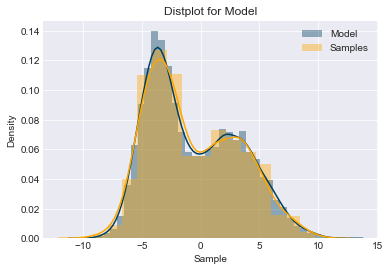

In [24]:
from dpm.monte_carlo import metropolis

samples = metropolis(p_model, keep_every=10, burn_in=1000, variance=3 * torch.eye(1), epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

torch.Size([900, 1])


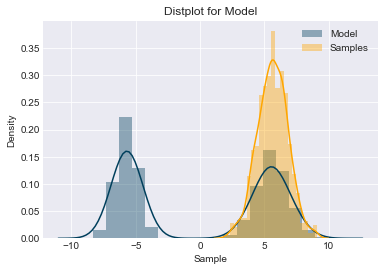

In [344]:


p_model = MixtureModel([Normal(-5.7, 0.7, learnable=False), 
                        Normal(5.6, 1.5, learnable=False)],
                       [0.5, 0.5])

q_model = partial(Normal, scale=3 * torch.eye(1), learnable=False)

samples = metropolis_hastings(p_model, q_model, keep_every=10, burn_in=1000, epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

torch.Size([900, 1])


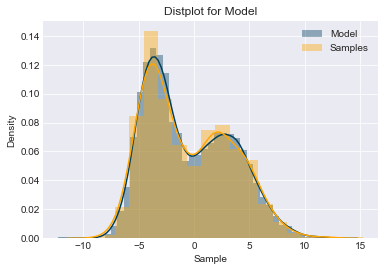

In [27]:

samples = metropolis_langevin(p_model, keep_every=10, burn_in=1000, epochs=10000)
print(samples.shape)
plot_hists(p_model.sample(10000), samples, labels=['Model', 'Samples'])

0.23032943904399872
0.23032943904399872
0.23032943904399872


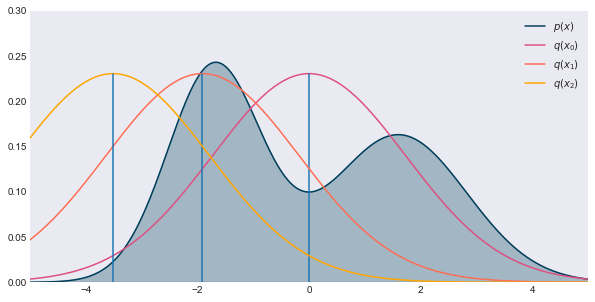

In [336]:
p_model = MixtureModel([Normal(-1.7, 0.7, learnable=False), 
                        Normal(1.6, 1.5, learnable=False)],
                       [0.5, 0.5])

plt.figure(figsize=(10, 5))
p_probs = p_model.log_prob(torch.tensor(x).float().view(-1, 1)).exp().detach().numpy()
plt.plot(x, p_probs, label=r"$p(x)$", color=colors[0])
plt.fill(x, p_probs, color=colors[0], alpha=0.3)

x = np.linspace(-7, 7, 1000).reshape(-1, 1)
x_i = 0.
for i in range(3):
    model = Normal(x_i, 3., learnable=False)
    x_i_1 = model.sample(1).item()

    q_probs = model.log_prob(torch.tensor(x).float().view(-1, 1)).exp().detach().numpy()

    plt.plot(x, q_probs, label=fr"$q(x_{i})$", color=colors[i+3])
    
    max_val = model.log_prob(x_i).exp().item()
    print(max_val)
    
    
    plt.axvline(x_i, ymin=0, ymax=(model.log_prob(x_i).exp().item() / (0.3)))
    
    x_i = x_i_1

plt.legend()
plt.xlim(-5, 5)
plt.ylim(0, 0.3)
plt.grid(b=None)


torch.Size([10000, 1])
torch.Size([10000, 1]) tensor(7.3587) tensor(-7.1654)
1000


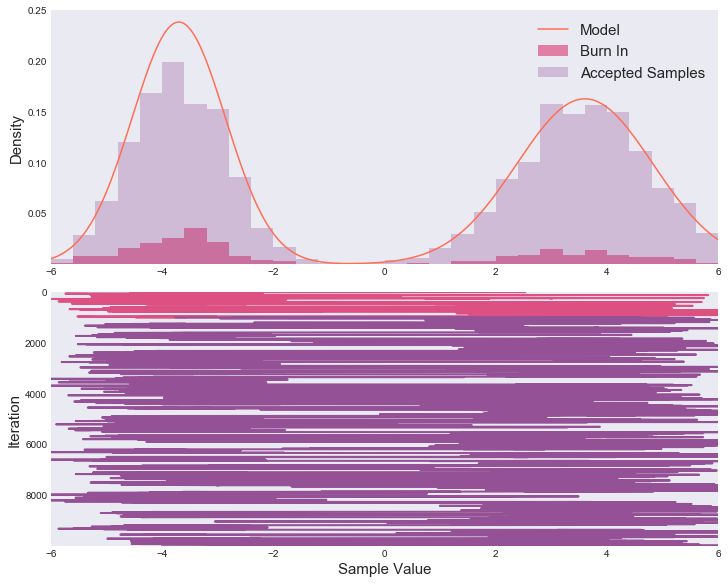

In [6]:
p_model = MixtureModel([Normal(-3.7, 0.7, learnable=False), 
                        Normal(3.6, 1.5, learnable=False)],
                       [0.5, 0.5])
var = 6
q_model = partial(Normal, scale=var * torch.eye(1), learnable=False)


burn_in = 1000
samples = metropolis_hastings(p_model, q_model, burn_in=0, epochs=10000, init=0.)
print(samples.shape)


fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,8))

hist, edges = np.histogram(samples.view(-1), bins=50, range=(-10., 10.), density=True)
print(samples.shape, samples.max(), samples.min())
burn_in_rate = []
print(burn_in)
sample_np = samples.view(-1).detach().numpy()
for i in range(50):
    num_burn_in = ((sample_np[:burn_in] > edges[i]) & (sample_np[:burn_in] <= edges[i+1])).sum()
    if hist[i] == 0:
        burn_in_rate.append(0)
    else:
        burn_in_rate.append(num_burn_in / len(samples) / hist[i] * hist.sum() )
burn_in_rate = np.array(burn_in_rate)
axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist*burn_in_rate, 
           width=edges[1] - edges[0], alpha=0.7, label="Burn In", color=colors[3])
axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist*(1-burn_in_rate), 
           width=edges[1] - edges[0], alpha=0.3, label="Accepted Samples", color=colors[2])


x = torch.tensor(np.linspace(-10., 10., 1000)).view(-1, 1).float()
p_probs = p_model.log_prob(x).exp()
axs[0].plot(x.numpy(), p_probs.numpy(), label='Model', color=colors[4])
# hist, edges = np.histogram(p_model.sample(10000).numpy(), bins=50, range=(-10., 10.), density=True)
# axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist, 
#            width=edges[1] - edges[0], alpha=0.3, label="Model", color=colors[4])

axs[0].set_ylabel("Density", fontsize=15)
axs[0].set_xlim(-6, 6)
axs[0].legend(prop={'size': 15})
axs[0].grid(b=None)
yticks = axs[0].yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)

x = np.linspace(0, len(samples), len(samples))
y = samples.squeeze(1).numpy()
axs[1].plot(y[:burn_in], x[:burn_in], color=colors[3], lw=2, label="Burn in")
axs[1].plot(y[burn_in:], x[burn_in:], color=colors[2], lw=2, label="Accepted Samples")
axs[1].set_xlabel("Sample Value", fontsize=15)
axs[1].set_ylabel("Iteration", fontsize=15)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(0, len(samples))
# axs[1].legend(loc='upper left', prop={'size': 15})
yticks = axs[1].yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.gca().invert_yaxis()
axs[1].grid(b=None)

plt.savefig(f'../../Presentations/sampling/assets/mcmc_{var}.png', bbox_inches='tight', dpi=300)

# plt.show()

torch.Size([10000, 1])
torch.Size([10000, 1]) tensor(7.4922) tensor(-6.3431)
1000


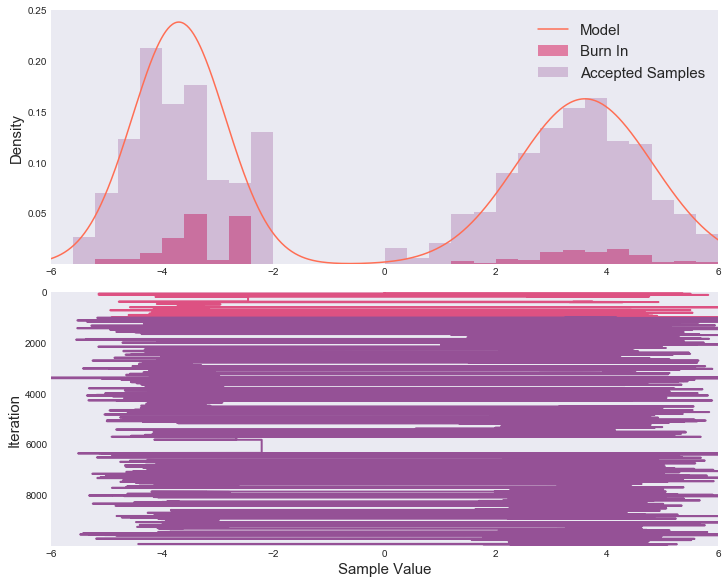

In [9]:
p_model = MixtureModel([Normal(-3.7, 0.7, learnable=False), 
                        Normal(3.6, 1.5, learnable=False)],
                       [0.5, 0.5])

burn_in = 1000
samples = metropolis_langevin(p_model, tau=6, burn_in=0, epochs=10000, init=0.)
print(samples.shape)


fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,8))

hist, edges = np.histogram(samples.view(-1), bins=50, range=(-10., 10.), density=True)
print(samples.shape, samples.max(), samples.min())
burn_in_rate = []
print(burn_in)
sample_np = samples.view(-1).detach().numpy()
for i in range(50):
    num_burn_in = ((sample_np[:burn_in] > edges[i]) & (sample_np[:burn_in] <= edges[i+1])).sum()
    if hist[i] == 0:
        burn_in_rate.append(0)
    else:
        burn_in_rate.append(num_burn_in / len(samples) / hist[i] * hist.sum() )
burn_in_rate = np.array(burn_in_rate)
axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist*burn_in_rate, 
           width=edges[1] - edges[0], alpha=0.7, label="Burn In", color=colors[3])
axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist*(1-burn_in_rate), 
           width=edges[1] - edges[0], alpha=0.3, label="Accepted Samples", color=colors[2])


x = torch.tensor(np.linspace(-10., 10., 1000)).view(-1, 1).float()
p_probs = p_model.log_prob(x).exp()
axs[0].plot(x.numpy(), p_probs.numpy(), label='Model', color=colors[4])
# hist, edges = np.histogram(p_model.sample(10000).numpy(), bins=50, range=(-10., 10.), density=True)
# axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist, 
#            width=edges[1] - edges[0], alpha=0.3, label="Model", color=colors[4])

axs[0].set_ylabel("Density", fontsize=15)
axs[0].set_xlim(-6, 6)
axs[0].legend(prop={'size': 15})
axs[0].grid(b=None)
yticks = axs[0].yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)

x = np.linspace(0, len(samples), len(samples))
y = samples.squeeze(1).numpy()
axs[1].plot(y[:burn_in], x[:burn_in], color=colors[3], lw=2, label="Burn in")
axs[1].plot(y[burn_in:], x[burn_in:], color=colors[2], lw=2, label="Accepted Samples")
axs[1].set_xlabel("Sample Value", fontsize=15)
axs[1].set_ylabel("Iteration", fontsize=15)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(0, len(samples))
# axs[1].legend(loc='upper left', prop={'size': 15})
yticks = axs[1].yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.gca().invert_yaxis()
axs[1].grid(b=None)

# plt.savefig(f'../../Presentations/sampling/assets/mcmc_lang_{3}.png', bbox_inches='tight', dpi=300)

# plt.show()

tensor([[-2.6114]]) tensor([[-0.5050]]) tensor([[-0.6064]]) tensor([0.1690])
tensor([[3.3889]]) tensor([[0.5277]]) tensor([[2.2612]]) tensor([0.0791])


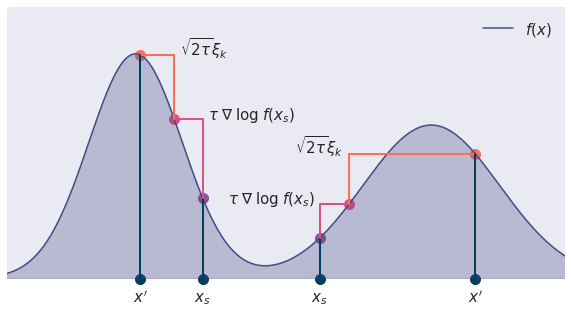

In [4]:
tau = 0.4


p_model = MixtureModel([Normal(-2.7, 0.7, learnable=False), 
                        Normal(2.6, 1.5, learnable=False)],
                       [0.5, 0.5])
noise = Normal(torch.zeros(1), (2. * tau) * torch.ones(1))

def log_prob(x_t, value, model):
    samples = x_t.expand_as(value)
    samples.requires_grad = True
    log_probs = model.log_prob(samples)
    noise_sample = samples - value + tau * gradient(log_probs, samples).squeeze(0)
    tmp = noise.log_prob(noise_sample).detach()
    return tmp

def sample(x_t, model, batch_size):
    samples = x_t.expand(batch_size, 1).detach()
    samples.requires_grad = True
    log_probs = model.log_prob(samples)
    eta = noise.sample(batch_size)
    g = tau * gradient(log_probs, samples).squeeze(0)
    samples = samples + g + eta
    return samples.detach(), g, eta


plt.figure(figsize=(10, 5))

x = torch.tensor(np.linspace(-10., 10., 1000)).view(-1, 1).float()
p_probs = p_model.log_prob(x).exp()
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.plot(x.numpy(), p_probs.numpy(), color=colors[1], label=r"$f(x)$")
plt.fill(x.numpy(), p_probs.numpy(), color=colors[1], alpha=0.3)

# run 2 step?
x_ts = [torch.tensor([[-1.5]]).float(), 
                         torch.tensor([[0.6]]).float()]
gs = [torch.tensor([[-0.5050]]), torch.tensor([[0.5277]]).float()]

etas = [torch.tensor([[-0.6064]]), torch.tensor([[2.2612]])]

for i in range(2):
    x_t = x_ts[i]
    x_t_prob = p_model.log_prob(x_t).exp()
#     x_s, g, eta = sample(x_t, p_model, 1)

#     g = g.detach()
    g = gs[i]
#     eta = eta.detach()
    eta = etas[i]
    x_s = x_t + g + eta
    x_s_prob = p_model.log_prob(x_s).exp()
    x_t_g = x_t + g
    x_t_g_prob = p_model.log_prob(x_t_g).exp()

    print(x_s, g, eta, x_t_g_prob)



    plt.annotate(r"$x_s$", (x_t.item(), 0), 
                 fontsize=15, xytext=(x_t.item(), -0.025), ha='center')

    plt.annotate(r"$x'$", (x_s.item(), 0),
                 fontsize=15, xytext=(x_s.item(), -0.025), ha='center')

    if i == 0:
        h = 'left'
        adj = .1
    else:
        h = 'right'
        adj = -.1
    plt.annotate(r"$\tau \; \nabla \; \log \; f (x_s)$", (x_t.item(), x_t_g_prob.item()),
                 fontsize=15, xytext=(x_t.item()+adj, x_t_g_prob.item()), ha=h)

    plt.annotate(r"$\sqrt{2 \tau} \xi_k$", (x_t_g.item(), x_s_prob.item()),
                 fontsize=15, xytext=(x_t_g.item()+adj, x_s_prob.item()), ha=h)

    plt.plot([x_t.item(), x_t.item()], [0., x_t_prob.item()],
             color=colors[0], clip_on=False, lw=2)
    plt.plot([x_t.item(), x_t.item(), x_t_g.item()], [x_t_prob.item(), x_t_g_prob.item(), x_t_g_prob.item()],
             color=colors[3], clip_on=False, lw=2)
    plt.plot([x_t_g.item(), x_t_g.item(), x_s.item()], [x_t_g_prob.item(), x_s_prob.item(), x_s_prob.item()],
             color=colors[4], clip_on=False, lw=2)
    plt.plot([x_s.item(), x_s.item()], [0., x_s_prob.item()],
             color=colors[0], clip_on=False, lw=2)

    plt.scatter(x_t.item(), x_t_prob.item(), s=100, color=colors[2], clip_on=False)
    plt.scatter(x_t_g.item(), x_t_g_prob.item(), s=100, color=colors[3], clip_on=False)
    plt.scatter(x_s.item(), x_s_prob.item(), s=100, color=colors[4], clip_on=False)

    plt.scatter(x_s.item(), 0, s=100, color=colors[0], clip_on=False)
    plt.scatter(x_t.item(), 0, s=100, color=colors[0], clip_on=False)

plt.xlim(-5, 5)
plt.ylim(0, np.max(p_probs.numpy()) + 0.05)
plt.grid(b=None)
plt.legend(loc='best', prop={'size': 15})

plt.savefig(f'../../Presentations/sampling/assets/mcmc_lang_visual.png', bbox_inches='tight', dpi=300)

plt.show()


In [243]:
p_model = MixtureModel([Normal(-3.7, 0.7, learnable=False), 
                        Normal(3.6, 1.5, learnable=False)],
                       [0.5, 0.5])

print(p_model)
samples = hamiltonian_monte_carlo(p_model, epsilon=.3, alpha=1.05, 
                                  epochs=2000, burn_in=200, 
                                  leapfrog=60)
print(samples.size())


MixtureModel(
  (models): ModuleList(
    (0): Normal()
    (1): Normal()
  )
)
Accept_rate 0.8872222222222222
torch.Size([1800, 1])


0.12950020678284405


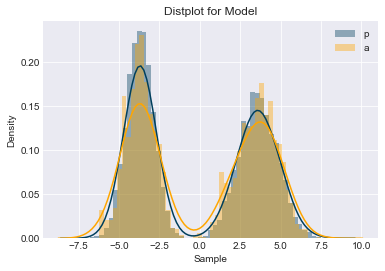

In [244]:
plot_hists(p_model.sample(10000), samples, labels=['p', 'a'])

hist_a, _ = np.histogram(samples, bins=50, range=(-10, 10), density=True)
hist_b, _ = np.histogram(p_model.sample(10000), bins=50, range=(-10, 10), density=True)
print((hist_b * np.log(hist_b+1e-10) - hist_b * np.log(hist_a+1e-10)).sum())

In [352]:

def U(q, model):
    return -model.log_prob(q)

def grad_U(q, model):
    q.requires_grad = True
    g = gradient(-model.log_prob(q), q).squeeze(0).detach()
    q.requires_grad = False
    return g


def hamiltonian_monte_carlo(model, epsilon=0.2, leapfrog=20, alpha=1., 
                            epochs=1000,
                            burn_in=1000, keep_every=1, init=None):
    if init is None:
        current_q = torch.rand((1, model.n_dims))
    else:
        current_q = init
        if not isinstance(current_q, torch.Tensor):
            current_q = torch.tensor(current_q).view(1, -1)

    samples = []
    count = 0
    for t in range(epochs):
        q = current_q.clone()
        p = torch.randn((q.size(1), 1))
        current_p = p.clone()

        p = p - epsilon * grad_U(q, model) / 2.

        for l in range(leapfrog):
            q = q + epsilon * p
            if l + 1 != leapfrog:
                if l < leapfrog / 2:
                    p = alpha * (p - epsilon * grad_U(q, model))
                else:
                    p = (1. / alpha) * (p - epsilon * grad_U(q, model))

        p = p - epsilon * grad_U(q, model) / 2.
        p = -p

        current_U = -model.log_prob(current_q)
        current_K = current_p.pow(2).sum() / 2.
        proposed_U = -model.log_prob(q)
        proposed_K = p.pow(2).sum() / 2.

        u = torch.rand(1).log()
        A = current_U - proposed_U + current_K - proposed_K
        if u < A:
            current_q = q
            if t >= burn_in:
                count += 1

        if t >= burn_in and t % keep_every == 0:
            samples.append(current_q)
    print(f'Accept_rate {count / (epochs-burn_in)}')
    return torch.cat(samples, dim=0)


def leapfrog_step(start, epsilon, model, alpha=1., p_start=None):
    path = []
    q = torch.tensor(start).view(-1, 1).float()
    if p_start is None:
        p = torch.randn((q.size(1), 1))
    else:
        p = p_start

    p = p - epsilon * grad_U(q, p_model) / 2.

    path.append(q.item())
    for l in range(leapfrog):
        q = q + epsilon * p
        path.append(q.item())
        if l + 1 != leapfrog:
            if l < leapfrog / 2:
                p = alpha * (p - epsilon * grad_U(q, model))
            else:
                p = (1. / alpha) * (p - epsilon * grad_U(q, model))

    return path



tensor([[-2.]]) tensor([1.7829])
tensor([[2.]]) tensor([1.9348])


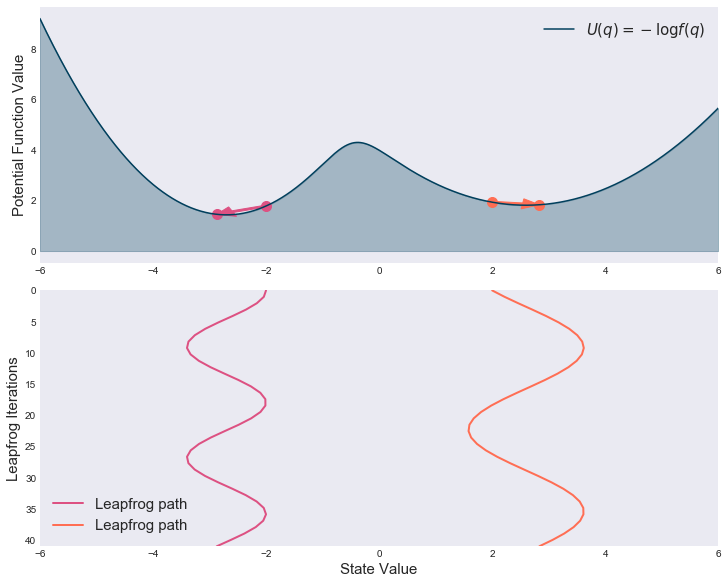

In [376]:
p_model = MixtureModel([Normal(-2.7, 0.7, learnable=False), 
                        Normal(2.6, 1.5, learnable=False)],
                       [0.5, 0.5])

leapfrog = 40
epsilon = 0.3
alpha = 1.00


x = torch.tensor(np.linspace(-6, 6, 1000)).float()
u_values = U(x.view(-1, 1), p_model)



# print(path)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,8))

axs[0].plot(x.numpy(), u_values.numpy(), color=colors[0], label=r"$U(q) = -\log f(q)$")
# axs[0].fill(x.numpy(), u_values.numpy(), color=colors[4], alpha=0.3)
axs[0].fill_between(x.numpy(), 0, u_values.numpy(), color=colors[0], alpha=0.3)

axs[0].set_ylabel(r"Potential Function Value", fontsize=15)
axs[0].set_xlim(-6, 6)
axs[0].legend(prop={'size': 15})
axs[0].grid(b=None)
yticks = axs[0].yaxis.get_major_ticks()
# yticks[0].label1.set_visible(False)

for i, start in enumerate([-2, 2]):
    path = leapfrog_step(start, epsilon, p_model, alpha)
    y = np.linspace(0, len(path), len(path))
    x = np.array(path)
    s = torch.tensor(path[0]).view(-1, 1).float()
    e = torch.tensor(path[-1]).view(-1, 1).float()
    axs[1].plot(x, y, color=colors[3+i], lw=2, label=f"Leapfrog path")
    print(s, U(s, p_model))
    axs[0].scatter(s, U(s, p_model).item(), s=100, color=colors[3+i], clip_on=False)
    axs[0].scatter(e, U(e, p_model).item(), s=100, color=colors[3+i], clip_on=False)
#     axs[0].plot([s, e], [U(s, p_model).item(), U(e, p_model).item()], color=colors[3+i])
    axs[0].arrow(s, U(s, p_model).item(),  e - s, U(e, p_model).item() - U(s, p_model).item(), 
             color=colors[3+i], head_width=0.4, head_length=0.3,
             width=0.07,
             length_includes_head=True)
    
axs[1].set_xlabel("State Value", fontsize=15)
axs[1].set_ylabel("Leapfrog Iterations", fontsize=15)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(0, len(path))
axs[1].legend(prop={'size': 15})
yticks = axs[1].yaxis.get_major_ticks()
# yticks[-1].label1.set_visible(False)
plt.gca().invert_yaxis()
axs[1].grid(b=None)

# plt.savefig(f'../../Presentations/sampling/assets/mcmc_lang_{3}.png', bbox_inches='tight', dpi=300)



tensor([[-0.]]) tensor([3.9946])
tensor([[-0.]]) tensor([3.9946])


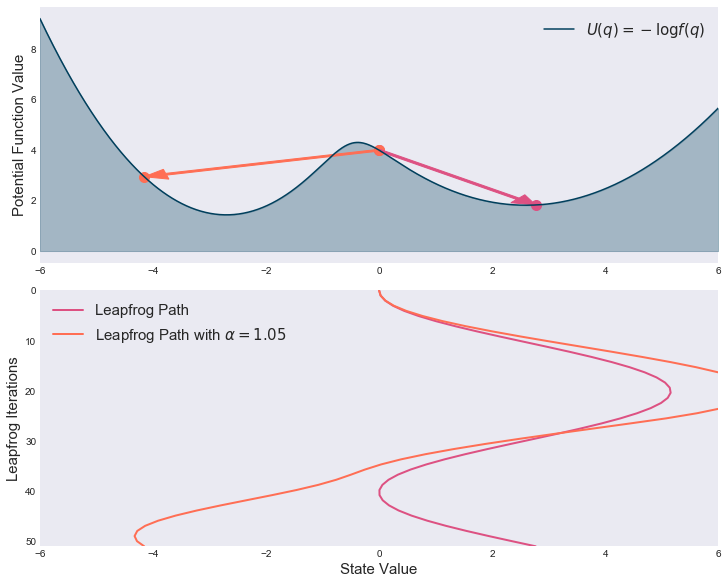

In [445]:
p_model = MixtureModel([Normal(-2.7, 0.7, learnable=False), 
                        Normal(2.6, 1.5, learnable=False)],
                       [0.5, 0.5])

leapfrog = 50
epsilon = 0.2
alpha = 1.05


x = torch.tensor(np.linspace(-6, 6, 1000)).float()
u_values = U(x.view(-1, 1), p_model)



# print(path)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,8))

axs[0].plot(x.numpy(), u_values.numpy(), color=colors[0], label=r"$U(q) = -\log f(q)$")
# axs[0].fill(x.numpy(), u_values.numpy(), color=colors[4], alpha=0.3)
axs[0].fill_between(x.numpy(), 0, u_values.numpy(), color=colors[0], alpha=0.3)



axs[0].set_ylabel(r"Potential Function Value", fontsize=15)
axs[0].set_xlim(-6, 6)
axs[0].legend(prop={'size': 15})
axs[0].grid(b=None)
yticks = axs[0].yaxis.get_major_ticks()
# yticks[0].label1.set_visible(False)

for i, start in enumerate([-0., -0.]):
    alpha = 1.05 if i == 1 else 1.0
    path = leapfrog_step(start, epsilon, p_model, alpha, 0)
    y = np.linspace(0, len(path), len(path))
    x = np.array(path)
    s = torch.tensor(path[0]).view(-1, 1).float()
    e = torch.tensor(path[-1]).view(-1, 1).float()
    label = "Leapfrog Path" if i == 0 else fr"Leapfrog Path with $\alpha={1.05}$"
    axs[1].plot(x, y, color=colors[3+i], lw=2, label=label)
    print(s, U(s, p_model))
    axs[0].scatter(s, U(s, p_model).item(), s=100, color=colors[3+i], clip_on=False)
    axs[0].scatter(e, U(e, p_model).item(), s=100, color=colors[3+i], clip_on=False)
    axs[0].arrow(s, U(s, p_model).item(),  e - s, U(e, p_model).item() - U(s, p_model).item(), 
                 color=colors[3+i], head_width=0.4, head_length=0.4,
                 width=0.07,
                 length_includes_head=True)
axs[1].set_xlabel("State Value", fontsize=15)
axs[1].set_ylabel("Leapfrog Iterations", fontsize=15)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(0, len(path))
axs[1].legend(prop={'size': 15})
yticks = axs[1].yaxis.get_major_ticks()
# yticks[-1].label1.set_visible(False)
plt.gca().invert_yaxis()
axs[1].grid(b=None)

# plt.savefig(f'../../Presentations/sampling/assets/mcmc_lang_{3}.png', bbox_inches='tight', dpi=300)




Accept_rate 0.9228282828282828
torch.Size([9900, 1])
torch.Size([9900, 1]) tensor(8.2632) tensor(-6.5511)


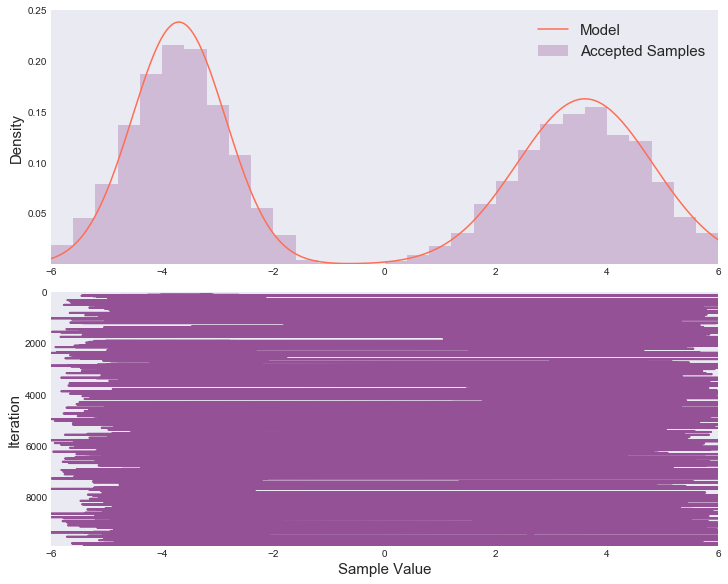

In [383]:
p_model = MixtureModel([Normal(-3.7, 0.7, learnable=False), 
                        Normal(3.6, 1.5, learnable=False)],
                       [0.5, 0.5])

burn_in = 100
samples = hamiltonian_monte_carlo(p_model, epsilon=.6, alpha=1.05, 
                                  epochs=10000, burn_in=burn_in, 
                                  leapfrog=40, init=0.0)
print(samples.shape)


fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,8))

hist, edges = np.histogram(samples[burn_in:].view(-1), bins=50, range=(-10., 10.), density=True)
print(samples.shape, samples.max(), samples.min())
# burn_in_rate = []
# print(burn_in)
# sample_np = samples.view(-1).detach().numpy()
# for i in range(50):
#     num_burn_in = ((sample_np[:burn_in] > edges[i]) & (sample_np[:burn_in] <= edges[i+1])).sum()
#     if hist[i] == 0:
#         burn_in_rate.append(0)
#     else:
#         burn_in_rate.append(num_burn_in / len(samples) / hist[i] * hist.sum() )
# burn_in_rate = np.array(burn_in_rate)
# axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist*burn_in_rate, 
#            width=edges[1] - edges[0], alpha=0.7, label="Burn In", color=colors[3])
axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist*(1-burn_in_rate), 
           width=edges[1] - edges[0], alpha=0.3, label="Accepted Samples", color=colors[2])


x = torch.tensor(np.linspace(-10., 10., 1000)).view(-1, 1).float()
p_probs = p_model.log_prob(x).exp()
axs[0].plot(x.numpy(), p_probs.numpy(), label='Model', color=colors[4])
# hist, edges = np.histogram(p_model.sample(10000).numpy(), bins=50, range=(-10., 10.), density=True)
# axs[0].bar(edges[:50]+(edges[1] - edges[0])/2, hist, 
#            width=edges[1] - edges[0], alpha=0.3, label="Model", color=colors[4])

axs[0].set_ylabel("Density", fontsize=15)
axs[0].set_xlim(-6, 6)
axs[0].legend(prop={'size': 15})
axs[0].grid(b=None)
yticks = axs[0].yaxis.get_major_ticks()
yticks[0].label1.set_visible(False)

x = np.linspace(0, len(samples), len(samples))
y = samples.squeeze(1).numpy()
# axs[1].plot(y[:burn_in], x[:burn_in], color=colors[3], lw=2, label="Burn in")
axs[1].plot(y[burn_in:], x[burn_in:], color=colors[2], lw=2, label="Accepted Samples")
axs[1].set_xlabel("Sample Value", fontsize=15)
axs[1].set_ylabel("Iteration", fontsize=15)
axs[1].set_xlim(-6, 6)
axs[1].set_ylim(0, len(samples))
# axs[1].legend(loc='upper left', prop={'size': 15})
yticks = axs[1].yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.gca().invert_yaxis()
axs[1].grid(b=None)

# plt.savefig(f'../../Presentations/sampling/assets/mcmc_lang_{3}.png', bbox_inches='tight', dpi=300)


# plt.show()